In [35]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

In [36]:
np.random.seed(0)

In [37]:
individuals = 50
cross_over_prob = 0.6
mutation_prob = 0.1

In [38]:
# load mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#images = np.concatenate((x_train, x_test))
#labels = np.concatenate((y_train, y_test))

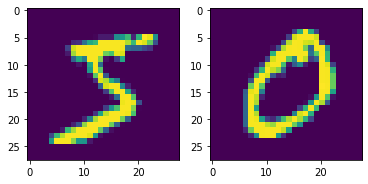

In [39]:
# example images
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_train[0]) 
ax[1].imshow(x_train[1])

In [130]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def p_fitness(individual, target, pred, label):
    # petras fitness fucntion
    return -(0.5*euclidean(individual-target) + 0.5*euclidean(pred-label))

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(150, np.sqrt(200))

def apply_noise(im):
    f = lambda t: t + gaussian_noise()
    return f(im) # apply mutation to pixes

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament_selection(pop, k, prob, target, label):
    tournament_indexes = np.random.choice(pop.shape[0], k, replace=False)
    candidates = pop[tournament_indexes]
    parent = [p_fitness(ind, target, svm.predict(ind.reshape(1, -1)), label) for ind in candidates]
    return candidates[parent.index(min(parent))]

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels

def init_pop_from_sample(n, num, data, labels):
    indices = np.where(labels==num)[0]
    index = np.random.choice(indices, 1)
    sample = np.take(data, index, axis=0)
    #f = lambda t: t + gaussian_noise()
    #np.array([i + gaussian_noise() for i in [sample for j in range(n)]])
    x = np.array([apply_noise(sample) for i in range(n)])
    return x.reshape(n, 784), sample

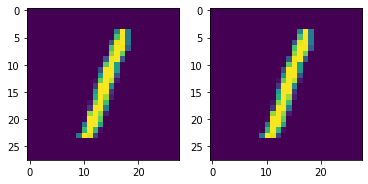

In [52]:
res, res2 = init_pop_from_sample(2, 1, X_t, y_test)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.array(res[0]).reshape(28,28)) 
ax[1].imshow(np.array(res[1]).reshape(28,28))

In [53]:
# train classifier on normal data
X = flatten(x_train)
X_t = flatten(x_test)
svm = SVC()
svm.fit(X, y_train)
svm.score(X_t, y_test)

0.9792

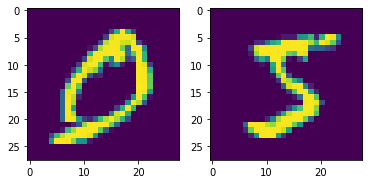

In [54]:
# Examples of crossover
v, w = k_crossover(X[0],X[1])
fig, ax = plt.subplots(1,2)
ax[0].imshow(v.reshape(28,28)) 
ax[1].imshow(w.reshape(28,28))

In [118]:
def run_ga(num, data, labels, n, max_iter, target):
    
    pop, ground_truth = init_pop_from_sample(n, num, data, labels) # initialize population by drawing from passed dataset
    for i in range(max_iter):
        parent1 = tournament_selection(pop, 3, 0.6, ground_truth, target)#, ground_truth, target) # select parent1
        parent2 = tournament_selection(pop, 3, 0.6, ground_truth, target)#, ground_truth, target) # select parent2
        child1, child2 = k_crossover(parent1, parent2) # crossover
        child1, child2 = apply_noise(child1), apply_noise(child2) # apply mutation to pixels
        predictions = svm.predict(pop) # predict using classifier
        scores = [p_fitness(pop[x], pop[x], predictions[x], 0) for x in range(n)] # get fitness values
        idx = np.argpartition(scores, 2)

In [124]:
run_ga(1, X, y_train, individuals, 1, 0)

[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


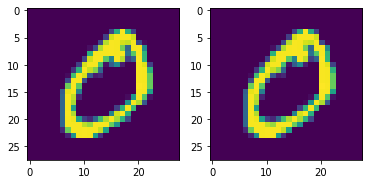

In [131]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(X[1].reshape(28,28)) 
ax[1].imshow(apply_noise(X[1]).reshape(28,28))

In [133]:
X[1],apply_noise(X[1])

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253,
        159,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238,
        252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0